# Azab Data by Kumparan (pt 2)

In [1]:
data_path="../data_raw/"
model_path="../model/"

In [2]:
%matplotlib inline
import re
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import nltk
from sklearn.feature_extraction.text import TfidfVectorizer


from gensim.models import Word2Vec
import seaborn as sns
from gensim.models.wrappers import FastText
from gensim.models import KeyedVectors

#bahasa stemmer
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
factory = StemmerFactory()
stemmer = factory.create_stemmer()

from wordcloud import WordCloud

### Cleaning Punctuation and create sentences list

In [281]:
# remove ibu from stopwords
stop_words_id=open(data_path+"stopwords_id.txt")
stop_words_id=list(set([i[:-1] for i in stop_words_id.readlines()]))
dtx=pd.read_csv(data_path+"data_azab.csv")
# re.sub( '\s+', ' ',


In [282]:
def remove_stops(X):
    X2=[]
    for c in X.split(" "):
        if len(c)>=2 and c not in stop_words_id:
            X2.append(c)
    return " ".join(X2)

def stem_process(X):
    X2=["zalim" if ("dzolim" in t)|("dzalim" in t)|("zalim" in t) else stemmer.stem(t) for t in X.split(" ")]
    X2=["orangtua" if ("orangtua" in t) | ("orang tua" in t) else t for t in X2 ]
#     [char.upper() if char != 'B' else char.lower() for char in "aBcDeF"]
    return " ".join(X2)

In [283]:
dtx["Judul2"]=dtx.Judul.apply(lambda x: re.sub(r"[@#?!$.,-:]\ *", " ",x).lower())
dtx["Judul2_no_stopwords"]=dtx.Judul2.apply(lambda x: remove_stops(x))
dtx["Judul2_ns_stem"]=dtx.Judul2_no_stopwords.apply(lambda x: stem_process(x))

In [284]:
dtx.to_csv(data_path+"data_azab_cln1.csv",index=False)

In [285]:
dtx.sample(10)

,Judul,Saluran TV,Judul2,Judul2_no_stopwords,Judul2_ns_stem
110,"Hancurkan Masjid, Anak Durhaka Mati Tertimbun ...",Indosiar,hancurkan masjid anak durhaka mati tertimbun d...,hancurkan masjid anak durhaka mati tertimbun j...,hancur masjid anak durhaka mati timbun jenazah...
140,"Hidup Tidak Berkah, Mati dengan Tangan dan Kak...",MNCTV,hidup tidak berkah mati dengan tangan dan kaki...,hidup berkah mati tangan kaki diluruskan,hidup berkah mati tangan kaki lurus
163,Bos Penadah Barang Curian Mati Tragis dan Jena...,MNCTV,bos penadah barang curian mati tragis dan jena...,bos penadah barang curian mati tragis jenazah ...,bos tadah barang curi mati tragis jenazah samb...
85,"Jenazah Orang yang Menggelapkan Uang, Kerandan...",Indosiar,jenazah orang yang menggelapkan uang kerandany...,jenazah orang menggelapkan uang kerandanya jat...,jenazah orang gelap uang keranda jatuh lumpur ...
173,Jenazah Perampok Sadis Masuk Ke Sungai,MNCTV,jenazah perampok sadis masuk ke sungai,jenazah perampok sadis masuk sungai,jenazah rampok sadis masuk sungai
11,Penghina Pengemis Mulutnya Terinfeksi Dan Jena...,Indosiar,penghina pengemis mulutnya terinfeksi dan jena...,penghina pengemis mulutnya terinfeksi jenazahn...,hina emis mulut infeksi jenazah bungkus karung...
82,Penjual Daging Oplosan mati Terjebak Perangkap...,Indosiar,penjual daging oplosan mati terjebak perangkap...,penjual daging oplosan mati terjebak perangkap...,jual daging oplos mati jebak perangkap celeng
70,"Orang Sok Dermawan Tapi Ternyata Pelit, Jenaza...",Indosiar,orang sok dermawan tapi ternyata pelit jenazah...,orang sok dermawan pelit jenazahnya terbang di...,orang sok dermawan pelit jenazah terbang kubur
103,Kain Kafan Jenazah Si Penjual Air Zam-Zam Pals...,Indosiar,kain kafan jenazah si penjual air zam zam pals...,kain kafan jenazah si penjual air zam zam pals...,kain kafan jenazah si jual air zam zam palsu b...
63,"Akibat Suka Sumpah Palsu, Tubuh Terkubur Hidup...",Indosiar,akibat suka sumpah palsu tubuh terkubur hidup ...,akibat suka sumpah palsu tubuh terkubur hidup ...,akibat suka sumpah palsu tubuh kubur hidup hid...


In [305]:
## Creates Sentences for Embedding

sentence=[]
# for il in dtext2.sample(15,random_state=100).item_list_cln2.tolist()[:10]:
for il in dtx.Judul2_no_stopwords.tolist():
    il2=il.split(" ")
    sentence.append(il2)    

In [306]:
## Creates Sentences for Embedding for MNCTV

sentence_mnc=[]
# for il in dtext2.sample(15,random_state=100).item_list_cln2.tolist()[:10]:
for il in dtx[dtx["Saluran TV"]=="MNCTV"].Judul2_ns_stem.tolist():
    il2=il.split(" ")
    sentence_mnc.append(il2)    

In [307]:
## Creates Sentences for Embedding for Indosiar

sentence_indo=[]
# for il in dtext2.sample(15,random_state=100).item_list_cln2.tolist()[:10]:
for il in dtx[dtx["Saluran TV"]=="Indosiar"].Judul2_ns_stem.tolist():
    il2=il.split(" ")
    sentence_indo.append(il2)    

In [308]:
len(sentence_indo),len(sentence_mnc)

(131, 63)

### Create embed from our sentences

In [309]:
# get all words to be maps
model_emb = Word2Vec(sentence,size=25,
        window=8,min_count=1,workers=5)

model_emb_mnc = Word2Vec(sentence_mnc,size=10,
        window=5,min_count=1,workers=5)

model_emb_indo = Word2Vec(sentence_indo,size=13,
        window=5,min_count=1,workers=5)

In [310]:
model_emb.train(sentence, total_examples=len(sentence), epochs=10)
model_emb_mnc.train(sentence_mnc, total_examples=len(sentence_mnc), epochs=10)
model_emb_indo.train(sentence_indo, total_examples=len(sentence_indo), epochs=10)

(7918, 11340)

In [311]:
# model_emb.wv.most_similar(positive="ibu",topn=20)

In [312]:
model_emb.corpus_count,model_emb_indo.corpus_count,model_emb_mnc.corpus_count

(194, 131, 63)

In [313]:
wcount={}
for word, vocab_obj in model_emb.wv.vocab.items():
    wcount[word]=vocab_obj.count
    
wcount_indo={}
for word, vocab_obj in model_emb_indo.wv.vocab.items():
    wcount_indo[word]=vocab_obj.count
    
wcount_mnc={}
for word, vocab_obj in model_emb_mnc.wv.vocab.items():
    wcount_mnc[word]=vocab_obj.count

In [314]:
wcount2=pd.Series(wcount)
wcount2_indo=pd.Series(wcount_indo)
wcount2_mnc=pd.Series(wcount_mnc)

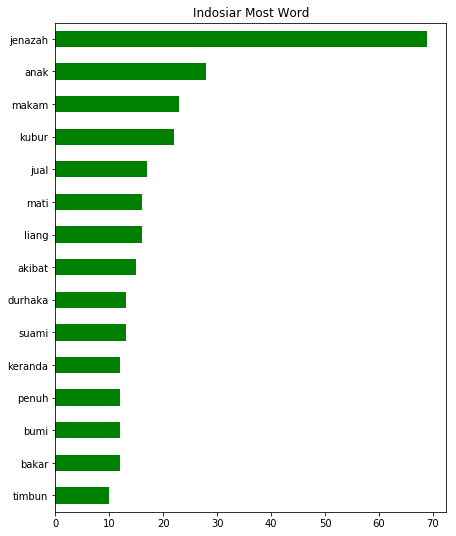

In [315]:
wcount2_indo.sort_values().tail(15).plot(kind="barh",figsize=(7,9),title="Indosiar Most Word",color="g")

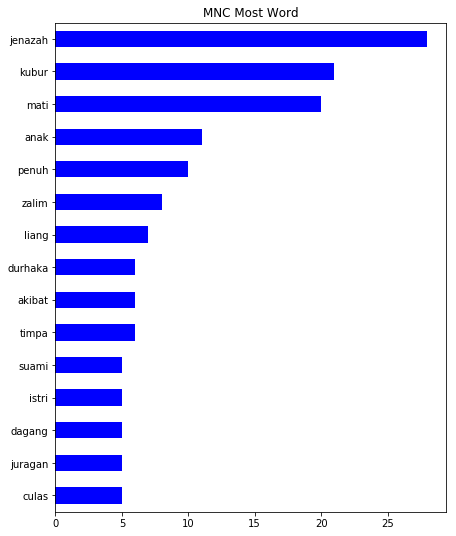

In [316]:
wcount2_mnc.sort_values().tail(15).plot(kind="barh",figsize=(7,9),title="MNC Most Word",color="b")

In [14]:
len(wcount2)

676

In [29]:
## get top 300 less used words
w_used=wcount2.sort_values(ascending=False)[-200:].index.tolist()

In [30]:
np.array(w_used)

array(['paman', 'makan', 'berdiri', 'gagu', 'mendadak', 'anjing',
       'diseren', 'toren', 'pemasung', 'judi', 'mesjid', 'misterius',
       'bicara', 'coran', 'cor', 'ratapan', 'terdengar', 'umroh', 'belut',
       'licin', 'menghindari', 'penjara', 'kepanasan', 'menggandakan',
       'gagal', 'majikan', 'terobsesi', 'disambar', 'meteor', 'kasar',
       'kotak', 'pemalak', 'memanjang', 'dadakan', 'tergoreng', 'bulat',
       'menguning', 'catering', 'pemandi', 'semburan', 'terpental',
       'sadis', 'perampok', 'kendara', 'menyiksa', 'pencemburu',
       'penyegel', 'menipu', 'hasil', 'menafkahi', 'jariyah', 'terbalik',
       'nisan', 'hutan', 'palak', 'preman', 'hisap', 'biro', 'sepasang',
       'menerjang', 'warisan', 'merampas', 'celeng', 'perangkap',
       'terputus', 'kafannya', 'amal', 'penebang', 'pemutus', 'kayu',
       'tewas', 'investasi', 'minum', 'debu', 'tenggorokan', 'serigala',
       'diinjak', 'peminta', 'sambar', 'tuanya', 'mencampakkan',
       'formalin', '

In [31]:
# save the embed
model_emb.save(model_path+'azab_vocab2.bin')

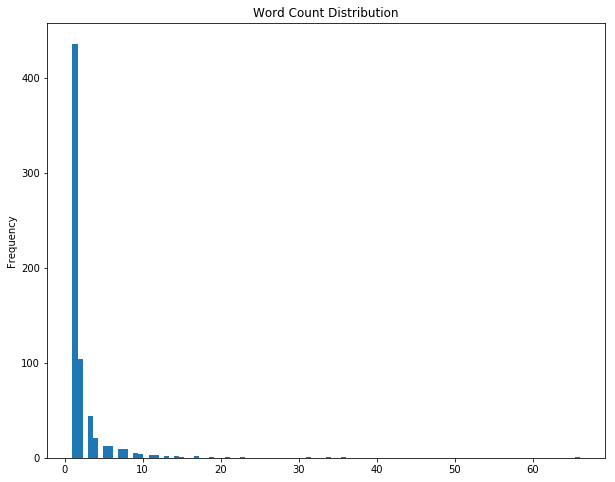

In [32]:
wcount2.plot(kind="hist",bins=100,figsize=(10,8), title="Word Count Distribution")

### Visualize embed

In [33]:
from sklearn.manifold import TSNE
import random

In [34]:
model_emb=Word2Vec.load(model_path+'azab_vocab2.bin')

In [35]:
ww=[]
wexp2=[]
weig=[]
for w0 in w_used:
    w1=model_emb.wv.most_similar(positive=w0,topn=10)
    ww+=[w[0] for w in w1]
    weig+=[w[1] for w in w1]
    wexp2+=[w0]*10

/Users/alamhanz/anaconda/envs/py36/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [36]:
ww2=[model_emb[w] for w in ww]

/Users/alamhanz/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


In [37]:
tsne_embds = TSNE(n_components=2).fit_transform(ww2)

In [38]:
len(tsne_embds)

2000

In [39]:
dwe_exp=pd.DataFrame(tsne_embds,columns=['x1','x2'])
dwe_exp["word"]=ww
dwe_exp["main_word"]=wexp2
dwe_exp["similar_score"]=weig

In [40]:
dwe_exp.to_csv(data_path+"viz_embed.csv",index=False)

In [41]:
dwe_exp[dwe_exp.similar_score>0.7]

,x1,x2,word,main_word,similar_score
380,-43.375591,118.826149,tua,pemandi,0.734972
630,53.026245,81.143837,istri,perangkap,0.781839
1150,-7.465365,29.895977,perampas,korupsi,0.755298
1170,143.103546,-34.526543,kontraktor,terseret,0.720322
1190,45.068684,-61.539001,kafan,terlantarkan,0.713437
1370,157.741623,-5.850121,tinggalkan,adukan,0.706624
1430,-202.233109,80.618362,pernikahan,fiktif,0.767902


### Embed use fast text

In [42]:
# model_f = FastText.load_word2vec_format(model_path+'/id_f/id.vec')
# embd_f= KeyedVectors.load_word2vec_format(model_path+'/id_f/id.vec')
# embd_f.load_binary_data(model_path+'/id_f/id.bin')

In [43]:
# dtx.head()

In [44]:
# embd_f.wv.most_similar(positive="anakku",topn=20)

### Analyze 1 (steps)

In [101]:
# jenazah, mayat
# liang lahat, lianglahat, kuburan, makam
# keranda
# mati

In [102]:
# dtx.sample(100)

In [103]:
dtx["mati"]=dtx.Judul2.str.contains(" mati ").astype(int)
dtx["jenazah"]=((dtx.Judul2.str.contains("jenazah"))|(dtx.Judul2_ns_stem.str.contains("jasad"))
              |(dtx.Judul2.str.contains("mayat"))).astype(int)
dtx["kuburan"]=((dtx.Judul2.str.contains("kuburan"))|
                (dtx.Judul2.str.contains("lianglahat"))|
                (dtx.Judul2.str.contains("liang lahat"))|
                (dtx.Judul2.str.contains("makam"))).astype(int)
dtx["keranda"]=dtx.Judul2_ns_stem.str.contains("keranda").astype(int)
dtx["penderitaan"]=(dtx[["mati","mayat","kuburan","keranda"]].sum(axis=1)==0).astype(int)

In [124]:
dtx[dtx.penderitaan==1]
# dtx[dtx.mati==1]
# dtx[dtx.mayat==1]
# dtx[dtx.keranda==1]
# dtx[dtx[["mati","jenazah","kuburan","keranda"]].sum(axis=1)>=3]["Judul"][88]

,Judul,Saluran TV,Judul2,Judul2_no_stopwords,Judul2_ns_stem,mati,mayat,kuburan,keranda,penderitaan,...,istri,wasiat,warisan,ortu,durhaka_ortu,len_txt,len_txt_ns,first_part,second_part,jenazah
0,Azab Suami Penakluk Wanita,Indosiar,azab suami penakluk wanita,azab suami penakluk wanita,azab suami takluk wanita,0,0,0,0,1,...,0,0,0,0,0,4,4,azab suami,penakluk wanita,0
3,"Akibat Mendzolimi Anak Yatim, Tubuh Bendahara ...",Indosiar,akibat mendzolimi anak yatim tubuh bendahara m...,akibat mendzolimi anak yatim tubuh bendahara m...,akibat dzolim anak yatim tubuh bendahara masji...,0,0,0,0,1,...,0,0,0,0,1,9,9,akibat mendzolimi anak yatim,tubuh bendahara masjid dihisap bumi,0
4,Anakku Ditolak Bumi Karena Hidup penuh Dosa,Indosiar,anakku ditolak bumi karena hidup penuh dosa,anakku ditolak bumi hidup penuh dosa,anak tolak bumi hidup penuh dosa,0,0,0,0,1,...,0,0,0,0,1,7,6,anakku ditolak bumi,hidup penuh dosa,0
5,Pencuri Yang Kehilangan Tangan Saat Akhir Haya...,Indosiar,pencuri yang kehilangan tangan saat akhir haya...,pencuri kehilangan tangan hayatnya,curi hilang tangan hayat,0,0,0,0,1,...,0,0,0,0,0,7,4,pencuri kehilangan,tangan hayatnya,0
6,Tangan dan Kaki Borokan Karena Mencuri Uang Or...,Indosiar,tangan dan kaki borokan karena mencuri uang or...,tangan kaki borokan mencuri uang orangtua,tangan kaki borok curi uang orangtua,0,0,0,0,1,...,0,0,0,1,1,8,6,tangan kaki borokan,mencuri uang orangtua,0
13,Mulut Bagai Terbakar Menjelang Ajal Si Penghin...,Indosiar,mulut bagai terbakar menjelang ajal si penghin...,mulut terbakar menjelang ajal si penghindar hu...,mulut bakar jelang ajal si hindar hutang,0,0,0,0,1,...,0,0,0,0,0,8,7,mulut terbakar menjelang,ajal si penghindar hutang,0
22,"Akibat Main Jimat, Si Musyirik Disiksa Di Akhirat",Indosiar,akibat main jimat si musyirik disiksa di akhirat,akibat main jimat si musyirik disiksa akhirat,akibat main jimat si musyirik siksa akhirat,0,0,0,0,1,...,0,0,0,0,0,8,7,akibat main jimat,si musyirik disiksa akhirat,0
28,Maut dan Siksa Menjemput Sang Istri Durhaka,Indosiar,maut dan siksa menjemput sang istri durhaka,maut siksa menjemput sang istri durhaka,maut siksa jemput sang istri durhaka,0,0,0,0,1,...,1,0,0,0,0,7,6,maut siksa menjemput,sang istri durhaka,0
34,"Akibat Tak Mengakui Anak Kandung, Mata Bagai D...",Indosiar,akibat tak mengakui anak kandung mata bagai di...,akibat mengakui anak kandung mata ditusuk seri...,akibat aku anak kandung mata tusuk ribu jarum,0,0,0,0,1,...,0,0,0,0,1,10,8,akibat mengakui anak kandung,mata ditusuk seribu jarum,0
36,"Mencuri Sumbangan Masjid, Tubuh Terbelenggu Semen",Indosiar,mencuri sumbangan masjid tubuh terbelenggu semen,mencuri sumbangan masjid tubuh terbelenggu semen,curi sumbang masjid tubuh belenggu semen,0,0,0,0,1,...,0,0,0,0,0,6,6,mencuri sumbangan masjid,tubuh terbelenggu semen,0


In [105]:
sal_co=dtx["Saluran TV"].value_counts()

In [106]:
d_tingkat_dosa=dtx.groupby("Saluran TV")["mati","jenazah","kuburan","keranda","penderitaan"].sum()
d_tingkat_dosa["All Data Count"]=sal_co

col_2=[]
for c in ["mati","jenazah","kuburan","keranda","penderitaan"]:
    d_tingkat_dosa[c+"_proportion"]=d_tingkat_dosa[c]/d_tingkat_dosa["All Data Count"]
    col_2.append(c+"_proportion")

In [107]:
d_tingkat_dosa[col_2]

,mati_proportion,jenazah_proportion,kuburan_proportion,keranda_proportion,penderitaan_proportion
Saluran TV,,,,,
Indosiar,0.122137,0.564885,0.335878,0.091603,0.137405
MNCTV,0.317460,0.444444,0.301587,0.031746,0.111111


In [146]:
# dtx["women"]=((dtx.Judul2_ns_stem.str.contains("wanita"))|
#                 (dtx.Judul2_ns_stem.str.contains("ibu"))|
#                 (dtx.Judul2_ns_stem.str.contains("istri"))|
#                 (dtx.Judul2_ns_stem.str.contains("perempuan"))).astype(int)

# dtx["harta"]=((dtx.Judul2_ns_stem.str.contains("harta"))|
#                 (dtx.Judul2_ns_stem.str.contains(" uang "))).astype(int)

In [147]:
# for XX in ["women","harta"]:
#     print(dtx[dtx["Saluran TV"]=="MNCTV"][[XX,"mati",
#             "jenazah","kuburan","keranda","penderitaan"]].corr()[XX])

In [148]:
# for XX in ["women","harta"]:
#     print(dtx[dtx["Saluran TV"]=="Indosiar"][[XX,"mati",
#             "jenazah","kuburan","keranda","penderitaan"]].corr()[XX])

### Analyze 2 (durhaka only)

In [130]:
model_emb.wv.most_similar(positive="keranda",topn=20)

/Users/alamhanz/anaconda/envs/py36/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('pengambil', 0.589604377746582),
 ('sampah', 0.5573948621749878),
 ('karyawan', 0.5269181132316589),
 ('lalai', 0.5221444368362427),
 ('yatim', 0.5168373584747314),
 ('vaksin', 0.46960020065307617),
 ('ratusan', 0.4675132930278778),
 ('timbangan', 0.4626060724258423),
 ('provokator', 0.4550347924232483),
 ('rentenir', 0.4456700384616852),
 ('gadis', 0.4428412616252899),
 ('bara', 0.4382106065750122),
 ('kambing', 0.43603792786598206),
 ('mandor', 0.4316137731075287),
 ('palsu', 0.4286765456199646),
 ('zalim', 0.4278440475463867),
 ('bekas', 0.4269106984138489),
 ('gosip', 0.4190877676010132),
 ('terseret', 0.40799596905708313),
 ('misterius', 0.4062816798686981)]

In [131]:
try_word1=["ibu","mama","ayah","papa"]
for x in try_word1:
    try:
        model_emb.wv.most_similar(positive=x,topn=20)
    except:
        print(x, "doesn't exist")

mama doesn't exist
papa doesn't exist


/Users/alamhanz/anaconda/envs/py36/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [132]:
# anak, durhaka, suami, istri, ibu, ayah, bapak

In [133]:
dtx["durhaka"]=dtx.Judul2.str.contains("durhaka").astype(int)
dtx["ibu"]=dtx.Judul2.str.contains("ibu").astype(int)
dtx["ayah"]=dtx.Judul2.str.contains("ayah").astype(int)
dtx["anak"]=dtx.Judul2.str.contains("anak").astype(int)
dtx["suami"]=dtx.Judul2.str.contains("suami").astype(int)
dtx["istri"]=dtx.Judul2.str.contains("istri").astype(int)
dtx["wasiat"]=dtx.Judul2.str.contains("wasiat").astype(int)
dtx["warisan"]=dtx.Judul2.str.contains("warisan").astype(int)

dtx["ortu"]=((dtx.Judul2.str.contains("orang tua"))|(dtx.Judul2.str.contains("orangtua"))).astype(int)

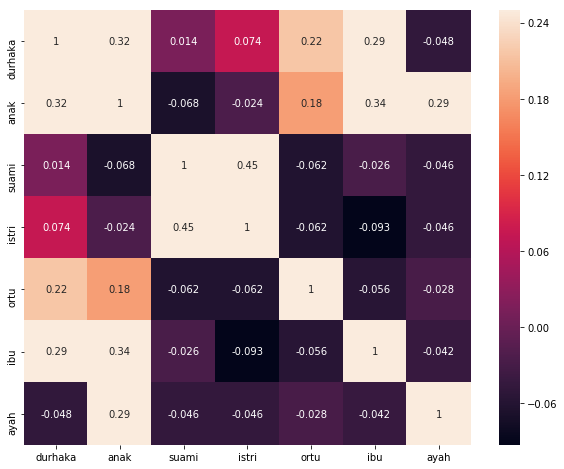

In [134]:
plt.figure(figsize=(10,8))
sns.heatmap(dtx[["durhaka","anak","suami","istri","ortu","ibu","ayah"]].corr(),vmax=0.25,annot=True)

In [135]:
# tak akui ibu kandung
dtx_anak_durhaka=dtx[((dtx.durhaka==1)|(dtx.anak==1)|(dtx.ibu==1)|(dtx.ayah==1)|
         (dtx.ortu==1)|(dtx.wasiat==1)|(dtx.warisan==1))&(~((dtx.istri==1)|(dtx.suami==1)))]

dtx_anak_durhaka2=dtx_anak_durhaka[dtx_anak_durhaka[["durhaka","anak","suami","istri",
                                                     "ortu","ibu","ayah"]].sum(axis=1)>1]

len(dtx_anak_durhaka2)/float(len(dtx))

0.12371134020618557

In [136]:
sal_co=dtx["Saluran TV"].value_counts()

In [137]:
dtx_anak_durhaka2["Saluran TV"].value_counts()/sal_co

Indosiar    0.152672
MNCTV       0.063492
Name: Saluran TV, dtype: float64

In [149]:
# dtx_anak_durhaka2
dtx["durhaka_ortu"]=(((dtx.durhaka==1)|(dtx.anak==1)|(dtx.ibu==1)|(dtx.ayah==1)|
         (dtx.ortu==1)|(dtx.wasiat==1)|(dtx.warisan==1))&(~((dtx.istri==1)|(dtx.suami==1)))).astype(int)
dtx["harta"]=((dtx.Judul2_ns_stem.str.contains("harta"))|
                (dtx.Judul2_ns_stem.str.contains(" uang "))).astype(int)

In [181]:
dG1=dtx[dtx["Saluran TV"]=="MNCTV"][["durhaka_ortu","harta","mati",
        "jenazah","kuburan","keranda","penderitaan"]].corr()[["durhaka_ortu","harta"]]
dG1_g=dG1.unstack().reset_index()
dG1_g.columns=["Dosa","Azab","Korelasi"]
dG1_g["TV"]="MNCTV"
dG1_g=dG1_g[dG1_g.Dosa!=dG1_g.Azab]

In [182]:
dG2=dtx[dtx["Saluran TV"]=="Indosiar"][["durhaka_ortu","harta","mati",
        "jenazah","kuburan","keranda","penderitaan"]].corr()[["durhaka_ortu","harta"]]
dG2_g=dG2.unstack().reset_index()
dG2_g.columns=["Dosa","Azab","Korelasi"]
dG2_g["TV"]="Indosiar"
dG2_g=dG2_g[dG2_g.Dosa!=dG2_g.Azab]

In [183]:
dGG=pd.concat([dG1_g,dG2_g])

In [197]:
dGG2=dGG.groupby(["Azab","Dosa","TV"]).mean()
dGG2.unstack().unstack()["Korelasi"]

TV               Indosiar                  MNCTV          
Dosa         durhaka_ortu     harta durhaka_ortu     harta
Azab                                                      
durhaka_ortu          NaN  0.031502          NaN  0.266800
harta            0.031502       NaN     0.266800       NaN
jenazah          0.075245  0.154687    -0.170747 -0.144437
keranda         -0.110091 -0.000728     0.120983 -0.053164
kuburan         -0.041401 -0.157037     0.147895  0.190909
mati             0.018635 -0.028875    -0.036454  0.052063
penderitaan     -0.006445 -0.040890    -0.067494  0.083045

------------------------------------------------------------------------------------------------------------

### Analyze 5 (pisah azab dan penyebabnya)

In [68]:
# tfidf (k-means)
def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems
#     return filtered_tokens

def wcloud(text,title0,title):
    wordcloud2 = WordCloud(width=800, height=400).generate(text)
    plt.figure(figsize=(12,12))
    plt.title(title0,fontsize=40,ha='center',va='bottom')
    plt.imshow(wordcloud2, interpolation='bilinear')
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.savefig(title)
    
def txt_f_part(dta):
    nn=int(dta["len_txt_ns"]/2)
    X=dta["Judul2_no_stopwords"].split(" ")
    X2=X[:nn]
    return " ".join(X2)
    
def txt_l_part(dta):
    nn=int(dta["len_txt_ns"]/2)
    X=dta["Judul2_no_stopwords"].split(" ")
    X2=X[nn:]
    return " ".join(X2)

In [69]:
pict_path="../pict/"

In [70]:
## bagi 2
dtx["len_txt"]=dtx.Judul2.apply(lambda x: len(x.split(" ")))
dtx["len_txt_ns"]=dtx.Judul2_ns_stem.apply(lambda x: len(x.split(" ")))
dtx["first_part"]=dtx.apply(txt_f_part,axis=1)
dtx["second_part"]=dtx.apply(txt_l_part,axis=1)


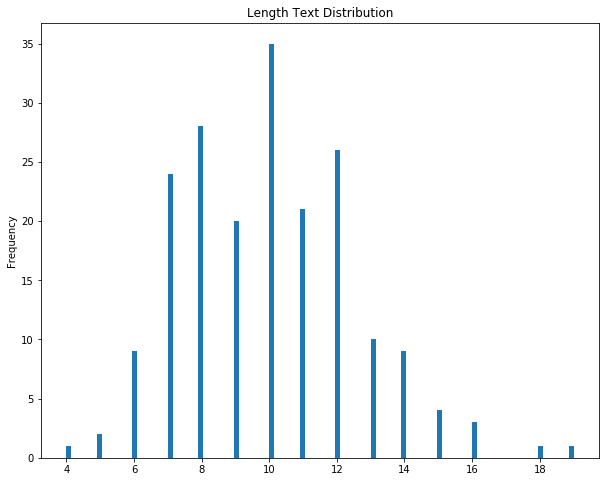

In [71]:
dtx.len_txt.plot(kind="hist",bins=100,figsize=(10,8), title="Length Text Distribution")

In [59]:
dtx.groupby(["Saluran TV"]).size()

Saluran TV
Indosiar    131
MNCTV        63
dtype: int64

In [60]:
dtx.len_txt.describe()

count    194.000000
mean       9.969072
std        2.585145
min        4.000000
25%        8.000000
50%       10.000000
75%       12.000000
max       19.000000
Name: len_txt, dtype: float64

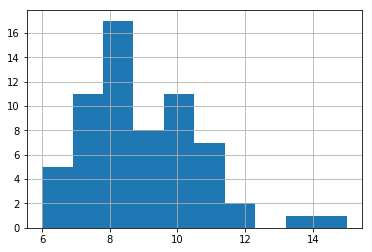

In [61]:
dtx[dtx["Saluran TV"]=="MNCTV"].len_txt.hist()

In [75]:
dtx.Judul.sample(3).as_matrix()

/Users/alamhanz/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if __name__ == '__main__':


array(['Jenazah Memanjang Azab Kepada Orang Yang Suka Mencuri Kotak Mesjid',
       'Pemalsu Kosmetik Terkubur Bersama Pohon Besar dan Keluar Asap',
       'Zalim Pada Karyawan, Bos Pabrik Jenazahnya Hilang Tertimbun Sampah'],
      dtype=object)

In [65]:
# create tf-idf from all judul

list_txt_f=dtx.first_part
list_txt_l=dtx.second_part

tv1 = TfidfVectorizer(max_df=0.99, max_features=50,
                                 min_df=0.001, stop_words=stop_words_id,
                                 use_idf=True, ngram_range=(1,3))

tv2 = TfidfVectorizer(max_df=0.99, max_features=50,
                                 min_df=0.001, stop_words=stop_words_id,
                                 use_idf=True, ngram_range=(1,3))

In [66]:
tv1.fit(list_txt_f)
tv2.fit(list_txt_l)

/Users/alamhanz/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:286: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['baiknya', 'berkali', 'kali', 'kurangnya', 'mata', 'olah', 'sekurang', 'setidak', 'tama', 'tidaknya'] not in stop_words.
  sorted(inconsistent))
/Users/alamhanz/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:286: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['baiknya', 'berkali', 'kali', 'kurangnya', 'mata', 'olah', 'sekurang', 'setidak', 'tama', 'tidaknya'] not in stop_words.
  sorted(inconsistent))


TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.99, max_features=50, min_df=0.001,
        ngram_range=(1, 3), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=['lanjut', 'tiba-tiba', 'wahai', 'beberapa', 'bukannya', 'jawabnya', 'apabila', 'tak', 'berikan', 'tidak', 'sebaiknya', 'dijelaskannya', 'lima', 'kapankah', 'menyiapkan', 'tepat', 'terbanyak', 'untuk', 'ujar', 'memisalkan', 'perlu', 'lanjutnya', 'mengatakan', 'tidaklah', 'sini', 'cukuplah...alah', 'dipertanyakan', 'yakni', 'menyatakan', 'adanya', 'mengenai', 'akhir', 'macam', 'dipastikan'],
        strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [67]:
tfidf_mat_f=tv1.transform(list_txt_f)
tfidf_mat_l=tv2.transform(list_txt_l)

In [68]:
 ## Clustering the topics into 5 Cluster
from sklearn.cluster import KMeans
km1 = KMeans(n_clusters=2, max_iter=1000, tol=0.01)
km2 = KMeans(n_clusters=2, max_iter=1000, tol=0.01)

In [69]:
km1.fit(tfidf_mat_f)
km2.fit(tfidf_mat_l)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=1000,
    n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.01, verbose=0)

In [70]:
dtx["cluster_f"]=km1.labels_
dtx["cluster_l"]=km2.labels_

In [72]:
dtx.groupby("cluster_l").count()["Judul"]

cluster_l
0    178
1     16
Name: Judul, dtype: int64

In [74]:
dtx.sample(10)

,Judul,Saluran TV,Judul2,Judul2_no_stopwords,Judul2_ns_stem,len_txt,len_txt_ns,first_part,second_part,cluster_f,cluster_l
46,Jenazah Tukang Ojek Serakah Pemakan Harta Saud...,Indosiar,jenazah tukang ojek serakah pemakan harta saud...,jenazah tukang ojek serakah pemakan harta saud...,jenazah tukang ojek serakah makan harta saudar...,13,11,jenazah tukang ojek serakah pemakan,harta saudara membuncit jatuh air terjun,1,0
145,Murka Ibu Membuat Keranda Anak Durhaka Tertanc...,MNCTV,murka ibu membuat keranda anak durhaka tertanc...,murka ibu keranda anak durhaka tertancap bambu,murka ibu keranda anak durhaka tancap bambu,8,7,murka ibu keranda,anak durhaka tertancap bambu,0,0
173,Jenazah Perampok Sadis Masuk Ke Sungai,MNCTV,jenazah perampok sadis masuk ke sungai,jenazah perampok sadis masuk sungai,jenazah rampok sadis masuk sungai,6,5,jenazah perampok,sadis masuk sungai,1,0
56,Liang Lahat Anak Tiri Mengecil Karena Durhaka ...,Indosiar,liang lahat anak tiri mengecil karena durhaka ...,liang lahat anak tiri mengecil durhaka ibu tiri,liang lahat anak tiri kecil durhaka ibu tiri,10,8,liang lahat anak tiri,mengecil durhaka ibu tiri,0,0
105,Penjual Cendol Berbahan Pewarna Tekstil dan Pe...,Indosiar,penjual cendol berbahan pewarna tekstil dan pe...,penjual cendol berbahan pewarna tekstil pemani...,jual cendol bahan warna tekstil man buat liang...,14,13,penjual cendol berbahan pewarna tekstil pemanis,buatan liang lahatnya mengeluarkan cairan berw...,0,0
47,"Akibat Dzalim Kepada Ayah, Keranda Jenazah Ana...",Indosiar,akibat dzalim kepada ayah keranda jenazah anak...,akibat dzalim ayah keranda jenazah anak disera...,akibat dzalim ayah keranda jenazah anak serang...,9,8,akibat dzalim ayah keranda,jenazah anak diserang lebah,0,0
172,"Akibat Mempermainkan Pernikahan, Kuburannya Di...",MNCTV,akibat mempermainkan pernikahan kuburannya dik...,akibat mempermainkan pernikahan kuburannya dik...,akibat main nikah kubur rubung hewan,6,6,akibat mempermainkan pernikahan,kuburannya dikerubungi hewan,0,0
174,Jenazah Terpental Semburan Gas di Liang Lahat,MNCTV,jenazah terpental semburan gas di liang lahat,jenazah terpental semburan gas liang lahat,jenazah pental sembur gas liang lahat,7,6,jenazah terpental semburan,gas liang lahat,1,0
149,"Akibat Merebut Suami Sahabat, Liang Lahatnya P...",MNCTV,akibat merebut suami sahabat liang lahatnya pe...,akibat merebut suami sahabat liang lahatnya pe...,akibat rebut suami sahabat liang lahatnya penu...,9,9,akibat merebut suami sahabat,liang lahatnya penuh kalajengking berbisa,0,0
158,Kepala Panti Asuhan Serakah Terjepit Liang Lah...,MNCTV,kepala panti asuhan serakah terjepit liang lah...,kepala panti asuhan serakah terjepit liang lah...,kepala panti asuh serakah jepit liang lahat sa...,9,9,kepala panti asuhan serakah,terjepit liang lahat tersapu banjir,0,0


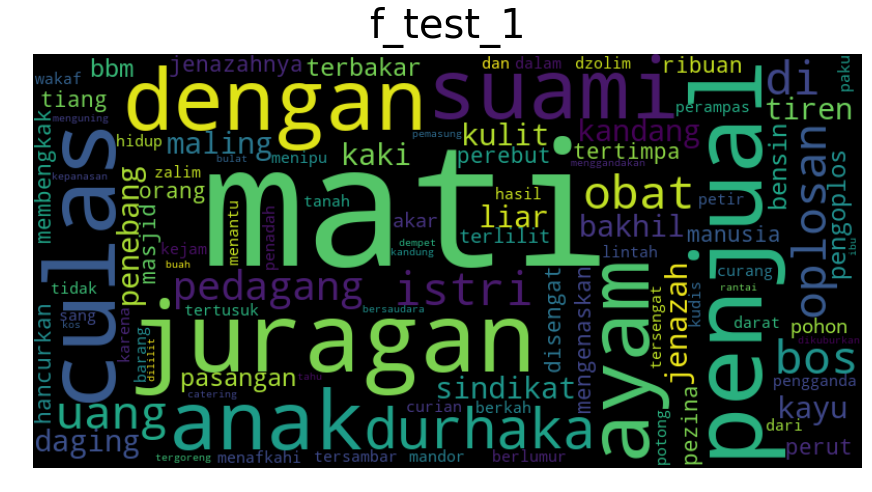

In [52]:
## Checking The Cluster1 
cl=1
tc0=' '.join(dtx[dtx.cluster_f==cl].first_part)
title0="f_test_"+str(cl)
title=pict_path+'test_f_most_word_'+str(cl)+'.png'
wcloud(tc0,title0,title)

In [157]:
dtx.head()

,Judul,Saluran TV,Judul2,Judul2_no_stopwords,Judul2_ns_stem,cluster_0
0,Azab Suami Penakluk Wanita,Indosiar,azab suami penakluk wanita,azab suami penakluk wanita,azab suami takluk wanita,0
1,Liang Lahat Anak Tiri Mengecil Karena Durhaka ...,Indosiar,liang lahat anak tiri mengecil karena durhaka ...,liang lahat anak tiri mengecil durhaka ibu tiri,liang lahat anak tiri kecil durhaka ibu tiri,4
2,Hujan Badai Mengiringi Pemakaman Penjual Liang...,Indosiar,hujan badai mengiringi pemakaman penjual liang...,hujan badai mengiringi pemakaman penjual liang...,hujan badai iring makam jual liang lahat,4
3,"Akibat Mendzolimi Anak Yatim, Tubuh Bendahara ...",Indosiar,akibat mendzolimi anak yatim tubuh bendahara m...,akibat mendzolimi anak yatim tubuh bendahara m...,akibat dzolim anak yatim tubuh bendahara masji...,3
4,Anakku Ditolak Bumi Karena Hidup penuh Dosa,Indosiar,anakku ditolak bumi karena hidup penuh dosa,anakku ditolak bumi hidup penuh dosa,anak tolak bumi hidup penuh dosa,3
